In [5]:
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow

In [7]:
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

In [12]:
!gdown 1yy_poZSFAPKi0y2e2yj9XDe1N8xXYuKB


Downloading...
From (original): https://drive.google.com/uc?id=1yy_poZSFAPKi0y2e2yj9XDe1N8xXYuKB
From (redirected): https://drive.google.com/uc?id=1yy_poZSFAPKi0y2e2yj9XDe1N8xXYuKB&confirm=t&uuid=01b37c24-8bfb-42ce-a847-b747cec4e90c
To: /content/gad.zip
100% 87.1M/87.1M [00:01<00:00, 54.7MB/s]


In [13]:
!unzip gad.zip

Archive:  gad.zip
  inflating: woman1.jpg              
  inflating: age_deploy.prototxt     
  inflating: age_net.caffemodel      
  inflating: gender_deploy.prototxt  
  inflating: gender_net.caffemodel   
  inflating: opencv_face_detector.pbtxt  
  inflating: opencv_face_detector_uint8.pb  
  inflating: woman3.jpg              
  inflating: girl1.jpg               
  inflating: girl2.jpg               
  inflating: kid1.jpg                
  inflating: man1.jpg                
  inflating: minion.jpg              
  inflating: gad.py                  


In [14]:
faceProto = "/content/opencv_face_detector.pbtxt"
faceModel = "/content/opencv_face_detector_uint8.pb"

ageProto = "/content/age_deploy.prototxt"
ageModel = "/content/age_net.caffemodel"

genderProto = "/content/gender_deploy.prototxt"
genderModel = "/content/gender_net.caffemodel"

In [15]:
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

In [16]:
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

In [17]:
padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        # print("Gender Output : {}".format(genderPreds))
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

Gender : Male, conf = 0.546
Age Output : [[0.00198876 0.00113449 0.05840764 0.00543933 0.67844504 0.05250545
  0.05059021 0.15148903]]
Age : (25-32), conf = 0.678


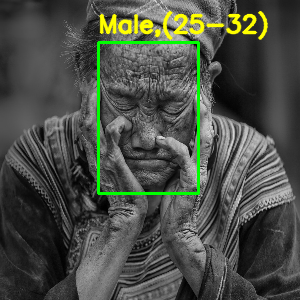

In [19]:
input = cv.imread("/content/man1.jpg")
resized = cv.resize(input, (300,300))
output = age_gender_detector(resized)
cv2_imshow(output)

Gender : Female, conf = 0.998
Age Output : [[2.81534284e-07 9.16232239e-07 2.56631116e-04 3.28092859e-03
  9.95189905e-01 1.14017597e-03 3.07280388e-05 1.00348596e-04]]
Age : (25-32), conf = 0.995


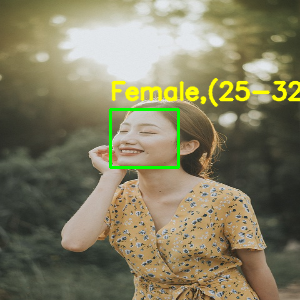

In [21]:
input = cv.imread("/content/girl1.jpg")
resized = cv.resize(input, (300,300))
output = age_gender_detector(resized)
cv2_imshow(output)

Gender : Female, conf = 0.994
Age Output : [[3.0734614e-04 2.3732950e-01 7.5751507e-01 5.3364004e-04 3.6087118e-03
  1.1782317e-04 3.5642902e-04 2.3154440e-04]]
Age : (8-12), conf = 0.758


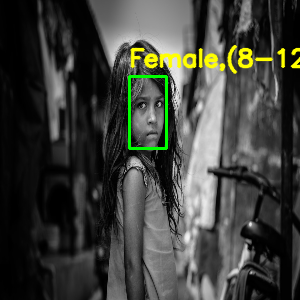

In [22]:
input = cv.imread("/content/girl2.jpg")
resized = cv.resize(input, (300,300))
output = age_gender_detector(resized)
cv2_imshow(output)

Gender : Male, conf = 0.997
Age Output : [[4.1418990e-01 5.3146929e-01 1.3251889e-02 1.3713839e-02 2.6428673e-02
  5.8573566e-04 2.6292741e-04 9.7752352e-05]]
Age : (4-6), conf = 0.531


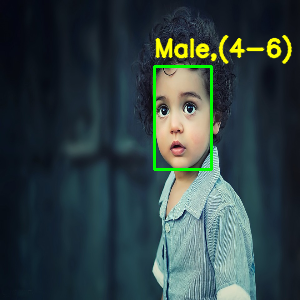

In [23]:
input = cv.imread("/content/kid1.jpg")
resized = cv.resize(input, (300,300))
output = age_gender_detector(resized)
cv2_imshow(output)

Gender : Female, conf = 1.000
Age Output : [[2.1189126e-05 4.2548138e-03 4.0879087e-03 1.4830980e-04 9.8165727e-01
  8.2482975e-03 1.4503625e-03 1.3171964e-04]]
Age : (25-32), conf = 0.982


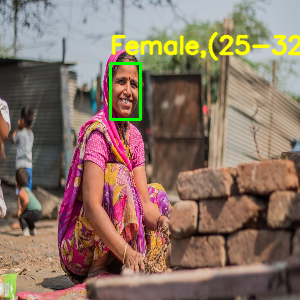

In [24]:
input = cv.imread("/content/woman1.jpg")
resized = cv.resize(input, (300,300))
output = age_gender_detector(resized)
cv2_imshow(output)

Gender : Female, conf = 0.999
Age Output : [[4.8569362e-09 7.6050710e-10 4.0264027e-07 1.9843444e-06 2.4519693e-03
  9.9752194e-01 2.0020598e-05 3.7047093e-06]]
Age : (38-43), conf = 0.998


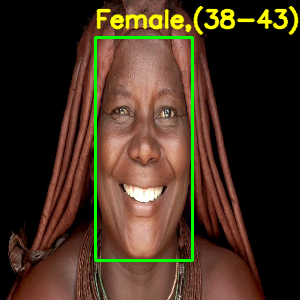

In [25]:
input = cv.imread("/content/woman3.jpg")
resized = cv.resize(input, (300,300))
output = age_gender_detector(resized)
cv2_imshow(output)